In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
16import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential, load_model
from keras.datasets import cifar100
from keras.layers import Dense, Input, Dropout
from keras.layers import Reshape, Flatten, Conv2D, Conv2DTranspose
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

(xtrain,_),(xtest,_) = cifar100.load_data()


rows = xtrain.shape[1]
cols = xtrain.shape[2]
channels = xtrain.shape[3]

xtrain_grey = np.dot(xtrain[...,:3],[0.299,0.587,0.144])
xtest_grey = np.dot(xtest[...,:3],[0.299,0.587,0.144])
xtrain = xtrain.astype('float32')/255
xtest = xtest.astype('float32')/255
xtrain_grey = xtrain_grey.astype('float32')/255
xtest_grey = xtest_grey.astype('float32')/255

xtrain = xtrain.reshape(xtrain.shape[0],rows,cols,channels)
xtest = xtest.reshape(xtest.shape[0],rows,cols,channels)
xtrain_grey = xtrain_grey.reshape(xtrain_grey.shape[0],rows,cols,1)
xtest_grey = xtest_grey.reshape(xtest_grey.shape[0],rows,cols,1)

split=int(0.80*len(xtrain))
xtr=xtrain[:split]
xtr_grey=xtrain_grey[:split]
xvalid=xtrain[split:]
xvalid_grey=xtrain_grey[split:]


enc_input = (rows,cols,1)
latent_dim = 256
layer_filters = [64,128,256]

inputs = Input(shape=enc_input)
x = inputs

for i in layer_filters:
    x = Conv2D(filters=i,kernel_size=3,strides=2,activation='relu',padding='same')(x)
    #x=Dropout(0.4)(x)
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim)(x)

encoder = Model(inputs,latent)

latent_inputs = Input(shape=(latent_dim,))
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for i in layer_filters[::-1]:
    x = Conv2DTranspose(filters=i,kernel_size=3,strides=2,activation='relu',padding='same')(x)
    #x=Dropout(0.4)(x)
outputs = Conv2DTranspose(filters=channels,kernel_size=3,activation='sigmoid',padding='same')(x)


BS=128


decoder = Model(latent_inputs,outputs)

autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(loss='mse',optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0005, amsgrad=False))
#weight_save_callback = ModelCheckpoint('colo50e32b20val.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',mode='auto')
aug = ImageDataGenerator(horizontal_flip=True)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.001
    if epoch >30 and epoch <=45:
        lr =0.0001
    if epoch >45 and epoch <=60:
        lr =0.00001
    
    return lr

checkpoin = ModelCheckpoint("checkpoint2", monitor='val_loss', verbose=1, save_best_only=True)
#callbacks_list = [checkpoint]
lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks=[lr_scheduler,checkpoin]
autoencoder = load_model("checkpoint2")
    # Finding the epoch index from which we are resuming
#initial_epoch = get_init_epoch("checkpoint2")

aug.fit(xtr_grey)
#aug.fit(xvalid_grey)
history = autoencoder.fit_generator(aug.flow(xtr_grey,xtr, batch_size=BS),validation_data=(xvalid_grey,xvalid),
steps_per_epoch=25000 ,epochs=60, callbacks=callbacks,initial_epoch=2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#history =autoencoder.fit(xtrain_grey,xtrain,validation_split=0.20,epochs=30,batch_size=32)
Model.save(autoencoder,'cifar10060e128b20valmultiplehypothesis.h5')

decoded_output = autoencoder.predict(xtest_grey)
imgs = decoded_output[:100]
imgs = imgs.reshape((10, 10, rows, cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
img = xtest[:100]
img = img.reshape((10, 10, rows, cols, channels))
img = np.vstack([np.hstack(i) for i in img])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Original)')
plt.imshow(img, interpolation='none')
plt.show()
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('Colorized_Output/color_img.png')
plt.show()

Using TensorFlow backend.


169009152/169001437 [==============================] - 2s 0us/step





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Epoch 3/60
   30/25000 [..............................] - ETA: 12:43:07 - loss: 0.0210

KeyboardInterrupt: ignored

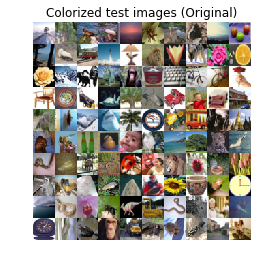

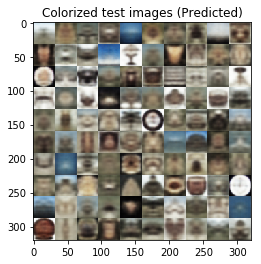

In [0]:
Model.save(autoencoder,'cifar100drpt0colo30e32b20valgene.h5')

decoded_output = autoencoder.predict(xtest_grey)
imgs = decoded_output[:100]
imgs = imgs.reshape((10, 10, rows, cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
img = xtest[:100]
img = img.reshape((10, 10, rows, cols, channels))
img = np.vstack([np.hstack(i) for i in img])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Original)')
plt.imshow(img, interpolation='none')
plt.show()
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('Colorized_Output/color_img.png')
plt.show()